# Autoscaling multi-tenant Kubernetes Deep-Dive

In this example we are going to take a deep-dive into launching an autoscaling multi-tenant RAPIDS environment on Kubernetes.

### Outline

- Get Kubernetes cluster
  - Launch GKE cluster with GPUs and autoscaling
  - Install NVIDIA Drivers
  - Install Prometheus with GPU addon
- Install RAPIDS
  - Install Dask Operator
  - Deploy RAPIDS prepuller (optional)
  - Deploy single notebook pod
- Run some work
  - Start with a simple Dask workload
  - Write a more complex Dask graph which spawns more Dask clusters and increases in intensity over time
  - Put autoscaling cluster through its paces
- Analyse Prometheus Data
  - Interesting data points
  - Average Dask worker pod wait time


### Prerequisites

Before we get started you'll need to ensure you have a few CLI tools installed.

- [`gcloud`](https://cloud.google.com/sdk/gcloud) (and make sure you run [`gcloud auth login`](https://cloud.google.com/sdk/gcloud/reference/auth/login))
- [`kubectl`](https://kubernetes.io/docs/tasks/tools/)
- [`helm`](https://helm.sh/docs/intro/install/)

## Get a Kubernetes Cluster

For this example we are going to use Google Cloud's Google Kubernetes Engine (GKE) to launch a cluster.

````{docref} /cloud/gcp/gke
We are going to follow the RAPIDS GKE deployment instructions but we will modify our cluster creation command to enable Kubernetes cluster autoscaling out of the box.

```
--num-nodes 1 --min-nodes 1 --max-nodes 20
```
````

In [44]:
! gcloud container clusters create multi-tenant-rapids \
    --accelerator type=nvidia-tesla-t4,count=2 --machine-type n1-standard-4 \
    --region us-central1 --node-locations us-central1-b,us-central1-c \
    --release-channel stable --enable-autoscaling \
    --num-nodes 1 --min-nodes 1 --max-nodes 20 \
    --autoscaling-profile optimize-utilization

Default change: VPC-native is the default mode during cluster creation for versions greater than 1.21.0-gke.1500. To create advanced routes based clusters, please pass the `--no-enable-ip-alias` flag
Default change: During creation of nodepools or autoscaling configuration changes for cluster versions greater than 1.24.1-gke.800 a default location policy is applied. For Spot and PVM it defaults to ANY, and for all other VM kinds a BALANCED policy is used. To change the default values use the `--location-policy` flag.
Note: Your Pod address range (`--cluster-ipv4-cidr`) can accommodate at most 1008 node(s).
Note: Machines with GPUs have certain limitations which may affect your workflow. Learn more at https://cloud.google.com/kubernetes-engine/docs/how-to/gpus
Creating cluster multi-tenant-rapids in us-central1... Cluster is being configu
red...⠼                                                                        
Creating cluster multi-tenant-rapids in us-central1... Cluster is bein

Now that we have our cluster let's install the NVIDIA Drivers.

In [45]:
! kubectl apply -f https://raw.githubusercontent.com/GoogleCloudPlatform/container-engine-accelerators/master/nvidia-driver-installer/cos/daemonset-preloaded-latest.yaml

daemonset.apps/nvidia-driver-installer created


## Observability

Once we have run some workloads on our Kubernetes cluster we will want to be able to go back through the cluster telemetry data to see how our autoscaling behaved. To do this let's install [Prometheus](https://prometheus.io/) and the [NVIDIA DCGM exporter](https://docs.nvidia.com/datacenter/cloud-native/gpu-telemetry/dcgm-exporter.html#) so that we are recording cluster metrics and can explore them later in [Grafana](https://grafana.com/).

### Prometheus stack

Let's start by installing the Prometheus Stack which includes the Prometheus Operator, Grafana and other components.

We need to add a couple of extra configuration options to ensure Prometheus is collecting our GPU metrics which you will find in `prometheus-stack-values.yaml`.

In [36]:
! cat prometheus-stack-values.yaml

# prometheus-stack-values.yaml
serviceMonitorSelectorNilUsesHelmValues: false

prometheus:
  prometheusSpec:
    # Setting this to a high frequency so that we have richer data for analysis later
    scrapeInterval: 1s

additionalScrapeConfigs:
  - job_name: gpu-metrics
    scrape_interval: 1s
    metrics_path: /metrics
    scheme: http
    kubernetes_sd_configs:
      - role: endpoints
        namespaces:
          names:
            - gpu-operator
    relabel_configs:
      - source_labels: [__meta_kubernetes_pod_node_name]
        action: replace
        target_label: kubernetes_node


In [46]:
! helm install --repo https://prometheus-community.github.io/helm-charts kube-prometheus-stack kube-prometheus-stack \
   --create-namespace --namespace prometheus \
   --values prometheus-stack-values.yaml

NAME: kube-prometheus-stack
LAST DEPLOYED: Tue Feb 21 09:19:39 2023
NAMESPACE: prometheus
STATUS: deployed
REVISION: 1
NOTES:
kube-prometheus-stack has been installed. Check its status by running:
  kubectl --namespace prometheus get pods -l "release=kube-prometheus-stack"

Visit https://github.com/prometheus-operator/kube-prometheus for instructions on how to create & configure Alertmanager and Prometheus instances using the Operator.


### DCGM Exporter

Now we can install the NVIDIA DCGM exporter which will read GPU metrics and make them available to Prometheus.

In [47]:
! helm install --repo https://nvidia.github.io/dcgm-exporter/helm-charts dcgm-exporter \
    --generate-name --namespace kube-system

NAME: dcgm-exporter-1676971345
LAST DEPLOYED: Tue Feb 21 09:22:31 2023
NAMESPACE: kube-system
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
1. Get the application URL by running these commands:
  export POD_NAME=$(kubectl get pods -n kube-system -l "app.kubernetes.io/name=dcgm-exporter,app.kubernetes.io/instance=dcgm-exporter-1676971345" -o jsonpath="{.items[0].metadata.name}")
  kubectl -n kube-system port-forward $POD_NAME 8080:9400 &
  echo "Visit http://127.0.0.1:8080/metrics to use your application"


Now that we have Prometheus running and collecting data we can move on and install RAPIDS and run some workloads. We will come back to these tools later when we want to explore the data we have collected.

## Install RAPIDS

For this RAPIDS installation we are going to use a single Jupyter Pod and the Dask Operator. In a real deployment you would likely use a service like [JupyterHub](https://jupyter.org/hub) or [Kubeflow Notebooks](https://www.kubeflow.org/docs/components/notebooks/) to create a notebook spawning service with user authentication, but that is out of scope for this example.

```{docref} /platforms/kubernetes
There are many ways to install RAPIDS on Kubernetes. You can find detailed instructions on all of the various methods in the documentation.
```

### Image prepuller (optional)

If you know that many users are going to want to frequently pull a specific container image I like to run a small `DaemonSet` which ensures that image gets pulled onto a node as soon as it joins the cluster. This is optional but can reduce wait time for users.

In [39]:
! cat image-prepuller.yaml

# image-prepuller.yaml
apiVersion: apps/v1
kind: DaemonSet
metadata:
  name: prepull-rapids
spec:
  selector:
    matchLabels:
      name: prepull-rapids
  template:
    metadata:
      labels:
        name: prepull-rapids
    spec:
      initContainers:
        - name: prepull-rapids
          image: rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu20.04-py3.9
          command: ["sh", "-c", "'true'"]
      containers:
        - name: pause
          image: gcr.io/google_containers/pause


In [48]:
! kubectl apply -f image-prepuller.yaml

daemonset.apps/prepull-rapids created


### RAPIDS Notebook Pod

Now let's launch a Notebook Pod. 

````{note}
From this Pod we are going to want to be able to spawn Dask cluster resources on Kubernetes, so we need to ensure the Pod has the appropriate permissions to interact with the Kubernetes API. 

```{docref} /platforms/kubernetes
Check out the extended notebook contiguration documentation for more details.
```
````

In [49]:
! kubectl apply -f rapids-notebook.yaml

serviceaccount/rapids-dask created
role.rbac.authorization.k8s.io/rapids-dask created
rolebinding.rbac.authorization.k8s.io/rapids-dask created
configmap/jupyter-server-proxy-config created
service/rapids-notebook created
pod/rapids-notebook created


### Install the Dask Operator

Lastly we need to install the Dask Operator so we can spawn RAPIDS Dask cluster from our Notebook session.

```{docref} /tools/kubernetes/dask-operator
See the RAPIDS Dask Operator documentation for more information.
```

In [50]:
! helm install --repo https://helm.dask.org dask-kubernetes-operator \
    --generate-name --create-namespace --namespace dask-operator 

NAME: dask-kubernetes-operator-1676971371
LAST DEPLOYED: Tue Feb 21 09:23:06 2023
NAMESPACE: dask-operator
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
Operator has been installed successfully.


## Running some work

Next let's connect to the Jupyter session and run some work on our cluster. You can do this by port forwarding the Jupyter service to your local machine.

```console
$ kubectl port-forward svc/rapids-notebook 8888:8888                                                                                                                        
Forwarding from 127.0.0.1:8888 -> 8888
Forwarding from [::1]:8888 -> 8888
```

Then open http://localhost:8888 in your browser.

```{note}
If you are following along with this notebook locally you will also want to upload it to the Jupyter session and continue running the cells from there.
```

### Check our capabilities

Let's make sure our environment is all set up correctly by checking out our capabilities. We can start by running `nvidia-smi` to inspect our Notebook GPU.

In [1]:
! nvidia-smi

Mon Feb 20 10:43:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Great we can see our notebook has an NVIDIA T4. Now let's use `kubectl` to inspect our cluster. We won't actually have `kubectl` installed in our remote Jupyter environment so let's do that first.

In [2]:
! mamba install --quiet -c conda-forge kubernetes-client -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [3]:
! kubectl get pods

NAME                   READY   STATUS    RESTARTS   AGE
prepull-rapids-2tz5w   1/1     Running   0          10m
prepull-rapids-cvcf4   1/1     Running   0          10m
rapids-notebook        1/1     Running   0          10m


We can see our prepull Pods we created earlier alongside our `rapids-notebook` Pod that we are currently in. As we created the prepull Pod via a `DaemonSet` we also know that there are two nodes in our Kubernetes cluster because there are two prepull Pods. As our cluster scales we will see more of them appear.

In [4]:
! kubectl get daskclusters

No resources found in default namespace.


We can also see that we currently have no `DaskCluster` resources, but this is good because we didn't get a `server doesn't have a resource type "daskclusters"` error so we know the Dask Operator also installed successfully.

### Small workload

Let's run a small RAPIDS workload that stretches our Kubernetes cluster a little and causes it to scale. 

We know that we have two nodes in our Kubernetes cluster and we selected a node type with 2 GPUs when we launched it on GKE. Our Notebook Pod is taking up one GPU so we have three remaining. If we launch a Dask Cluster we will need one GPU for the scheduler and one for each worker. So let's create a Dask cluster with two workers which will cause our Kubernetes to add one more node.

First let's install `dask-kubernetes` so we can create our `DaskCluster` resources from Python. We will also install `gcsfs` so that our workload can read data from Google Cloud Storage.

In [5]:
! mamba install --quiet -c conda-forge dask-kubernetes gcsfs -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [6]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(
    name="rapids-dask-1",
    image="rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu20.04-py3.9",
    n_workers=4,
    resources={"limits": {"nvidia.com/gpu": "1"}},
    env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs"},
    worker_command="dask-cuda-worker",
)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f7a39c2f880>
Unclosed connection
client_connection: Connection<ConnectionKey(host='10.32.0.1', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


Great our cluster was created but right now we just have a scheduler with half of our workers. We can use `kubectl` to see what is happening.

In [9]:
! kubectl get pods

NAME                                      READY   STATUS    RESTARTS   AGE
prepull-rapids-2tz5w                      1/1     Running   0          14m
prepull-rapids-cvcf4                      1/1     Running   0          14m
rapids-dask-1-default-worker-5d4690dcfa   0/1     Pending   0          89s
rapids-dask-1-default-worker-8cf93336f5   0/1     Pending   0          89s
rapids-dask-1-default-worker-af1133dca3   1/1     Running   0          89s
rapids-dask-1-default-worker-c4f7888317   1/1     Running   0          89s
rapids-dask-1-scheduler                   1/1     Running   0          90s
rapids-notebook                           1/1     Running   0          14m


We see here that most of our Pods are `Running` but two workers are `Pending`. This is because we don't have enough GPUs for them right now. We can look at the events on our pending pods for more information.

In [11]:
! kubectl get event --field-selector involvedObject.name=rapids-dask-1-default-worker-8cf93336f5

LAST SEEN   TYPE      REASON             OBJECT                                        MESSAGE
13s         Warning   FailedScheduling   pod/rapids-dask-1-default-worker-8cf93336f5   0/2 nodes are available: 2 Insufficient nvidia.com/gpu.
60s         Normal    TriggeredScaleUp   pod/rapids-dask-1-default-worker-8cf93336f5   pod triggered scale-up: [{https://www.googleapis.com/compute/v1/projects/nv-ai-infra/zones/us-central1-b/instanceGroups/gke-multi-tenant-rapids-default-pool-efbe942a-grp 1->2 (max: 20)}]


Here we can see that our Pod triggered the cluster to scale from one to two nodes. If we wait for our new node to come online we should see a few things happen. 

- First there will be a new prepull Pod scheduled on the new node which will start downloading the RAPIDS container image.
- Other Pods in the `kube-system` namespace will be scheduled to install NVIDIA drivers and update the Kubernetes API.
- Then once the GPU drivers have finished installing the worker Pods will be scheduled onto our new node
- Then once the image is ready our Pods move into a `Running` phase.

In [12]:
! kubectl get pods -w

NAME                                      READY   STATUS    RESTARTS   AGE
prepull-rapids-2tz5w                      1/1     Running   0          14m
prepull-rapids-cvcf4                      1/1     Running   0          14m
rapids-dask-1-default-worker-5d4690dcfa   0/1     Pending   0          110s
rapids-dask-1-default-worker-8cf93336f5   0/1     Pending   0          110s
rapids-dask-1-default-worker-af1133dca3   1/1     Running   0          110s
rapids-dask-1-default-worker-c4f7888317   1/1     Running   0          110s
rapids-dask-1-scheduler                   1/1     Running   0          111s
rapids-notebook                           1/1     Running   0          14m
prepull-rapids-fkb6w                      0/1     Pending   0          0s
prepull-rapids-fkb6w                      0/1     Pending   0          0s
prepull-rapids-fkb6w                      0/1     Init:0/1   0          4s
rapids-dask-1-default-worker-8cf93336f5   0/1     Pending    0          2m25s
rapids-dask-1-defau

Awesome we can now run some work on our Dask cluster.

In [13]:
from dask.distributed import Client, wait

client = Client(cluster)
client

<Client: 'tcp://10.28.1.16:8786' processes=2 threads=2, memory=29.30 GiB>

Let's load some data from GCS into memory on our GPUs.

In [15]:
%%time
import dask.config
import dask.dataframe as dd

dask.config.set({"dataframe.backend": "cudf"})

df = dd.read_parquet(
    "gcs://anaconda-public-data/nyc-taxi/2015.parquet",
    storage_options={"token": "cloud"},
).persist()
wait(df)
df

CPU times: user 6.18 s, sys: 1.23 s, total: 7.41 s
Wall time: 2min 2s


,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=50,,,,,,,,,,,,,,,,,,
,int32,datetime64[ns],int32,float64,float64,float64,int32,object,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Now we can do some calculation. This can be whatever you want to do with your data, for this example let's do something quick like calculating the haversine distance between the pickup and dropoff locations (yes calculating this on ~100M rows is a quick task for RAPIDS 😁).

In [16]:
from cuspatial import haversine_distance


def map_haversine(part):
    return haversine_distance(
        part["pickup_longitude"],
        part["pickup_latitude"],
        part["dropoff_longitude"],
        part["dropoff_latitude"],
    )


df["haversine_distance"] = df.map_partitions(map_haversine)

/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/join/_join_helpers.py:105: UserWarning: Can't safely cast column from int64 to datetime64[ns], upcasting to None.
  warnings.warn(


In [17]:
%%time
df["haversine_distance"].compute()

CPU times: user 1.75 s, sys: 1.72 s, total: 3.47 s
Wall time: 8.62 s


tpep_pickup_datetime
2015-01-01 00:00:00       4.326464
2015-01-01 00:00:00    8666.633292
2015-01-01 00:00:00       1.285498
2015-01-01 00:00:01       0.827326
2015-01-01 00:00:03       2.267110
                          ...     
2015-12-31 23:59:56       1.570824
2015-12-31 23:59:58       2.340270
2015-12-31 23:59:59       2.801575
2015-12-31 23:59:59       5.091840
2015-12-31 23:59:59       0.927577
Name: haversine_distance, Length: 146112989, dtype: float64

Great, so we now have a little toy workloads that opens some data, does some calculation and takes 1-2 minutes.

Let's remove our single Dask cluster and switch to simulating many workloads running at once.

In [18]:
client.close()
cluster.close()

## Simulating many multi-tenant workloads

Now we have a toy workload which we can use to represent one user on our multi-tenant cluster.

Let's now construct a larger graph to simulate lots of users spinning up Dask clusters and running workloads.

First let's create a function that contains our whole workload including our cluster setup.

In [212]:
import dask.delayed


@dask.delayed
def run_haversine(*args):
    from dask_kubernetes.operator import KubeCluster
    from dask.distributed import Client, wait
    import uuid
    import dask.config
    import dask.dataframe as dd

    dask.config.set({"dataframe.backend": "cudf"})

    def map_haversine(part):
        from cuspatial import haversine_distance

        return haversine_distance(
            part["pickup_longitude"],
            part["pickup_latitude"],
            part["dropoff_longitude"],
            part["dropoff_latitude"],
        )

    with KubeCluster(
        name="rapids-dask-" + uuid.uuid4().hex[:5],
        image="rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu20.04-py3.9",
        n_workers=2,
        resources={"limits": {"nvidia.com/gpu": "1"}},
        env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs"},
        worker_command="dask-cuda-worker",
        resource_timeout=600,
    ) as cluster:
        with Client(cluster) as client:
            client.wait_for_workers(2)
            df = dd.read_parquet(
                "gcs://anaconda-public-data/nyc-taxi/2015.parquet",
                storage_options={"token": "cloud"},
            )
            client.compute(df.map_partitions(map_haversine))

Now if we run this function we will launch a Dask cluster and run our workload. We will use context managers to ensure our Dask cluster gets cleaned up when the work is complete. Given that we have no active Dask clusters this function will be executed on the Notebook Pod.

In [26]:
%%time
run_haversine().compute()

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f79b05fd730>


CPU times: user 693 ms, sys: 1.11 s, total: 1.8 s
Wall time: 2min 57s


Great that works, so we have a self contained RAPIDS workload that runs in around two minutes.

### Simulating our multi-tenant workloads

To see how our Kubernetes cluster behaves when many users are sharing it we want to run our haversine workload a bunch of times. If you're not interested in how we simulate this workload feel free to skip onto the analysis section.

To do this we can create another Dask cluster which we will use to pilot our workloads. This cluster will be a proxy for the Jupyter sessions our users would be interacting with. We can set the cluster to autoscale as we throw work at it to simulate  and we will construct a Dask graph which runs our haversine workload many times in various configurations to simulate different users submitting different workloads on an ad-hoc basis.

In [213]:
from dask_kubernetes.operator import KubeCluster, make_cluster_spec

cluster_spec = make_cluster_spec(
    name="mock-jupyter-cluster",
    image="rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu20.04-py3.9",
    n_workers=1,
    resources={"limits": {"nvidia.com/gpu": "1"}, "requests": {"cpu": "50m"}},
    env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs dask-kubernetes"},
)
cluster_spec["spec"]["worker"]["spec"]["serviceAccountName"] = "rapids-dask"

cluster = KubeCluster(custom_cluster_spec=cluster_spec)
cluster

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f78b50f7af0>


Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.28.10.23:8786,Workers: 0
Dashboard: /proxy/10.28.10.23:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


We need to ensure our workers have the same dependencies as our Notebook session here so that it can spawn more Dask clusters so we install `dask-kubernetes`.

In [214]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,
Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.28.10.23:8786,Workers: 0
Dashboard: /proxy/10.28.10.23:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Now lets submit our workload again but this time to our cluster. Our function will be sent to our "Jupyter" worker which will then spawn another Dask cluster to run the workload. We don't have enough GPUs in our cluster to do this so it will trigger another scale operation.

In [45]:
%%time
run_haversine().compute()

CPU times: user 1.28 s, sys: 21.7 ms, total: 1.3 s
Wall time: 35.5 s


Not let's write a small function which we can use to build up arbitrarily complex workloads. We can define how many stages we have, how many concurrent Dask clusters their should be, how quickly to vary width over time, etc.

In [31]:
from random import randrange


def generate_workload(
    stages=3, min_width=1, max_width=3, variation=1, input_workload=None
):
    graph = [input_workload] if input_workload is not None else [run_haversine()]
    last_width = min_width
    for stage in range(stages):
        width = randrange(
            max(min_width, last_width - variation),
            min(max_width, last_width + variation) + 1,
        )
        graph = [run_haversine(*graph) for _ in range(width)]
        last_width = width
    return run_haversine(*graph)

In [215]:
cluster.scale(3)  # Let's also bump up our user cluster to show more users logging in.

To visualize our graphs let's check that we have `graphviz` installed.

In [33]:
!mamba install -c conda-forge --quiet graphviz python-graphviz -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 

done


Let's start with a small workload which will run a couple of stages and trigger a scale up.

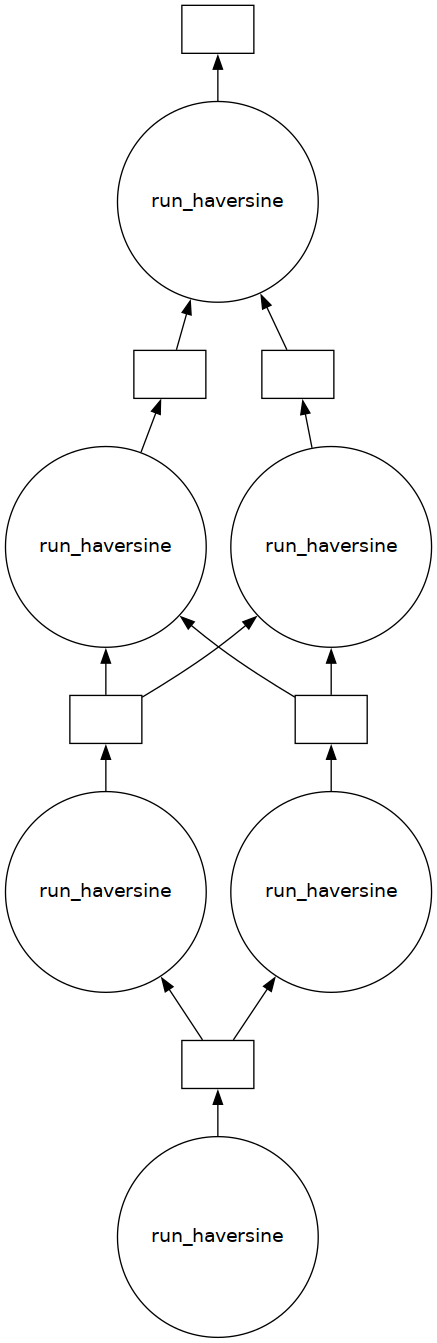

In [35]:
workload = generate_workload(stages=2, max_width=2)
workload.visualize()

In [36]:
%%time
workload.compute()

CPU times: user 44.8 s, sys: 782 ms, total: 45.6 s
Wall time: 21min 53s


Ok great now let's do the same again but let it run for a bit longer.

In [ ]:
generate_workload(stages=10, max_width=2).compute()

Now lets add a broader workload onto the end so we can make our cluster scale up again.

In [38]:
%%time
thin_workload = generate_workload(stages=5, max_width=2)
generate_workload(
    stages=5, max_width=5, min_width=3, variation=5, input_workload=thin_workload
).compute()

KeyboardInterrupt: 

Ok for our finale let's simulate a workload which decreases in demand again for a while before increasing again. This could represent how demand would behave over a lunchbreak or some other lull in the day.

In [44]:
import datetime

'2023-02-20-T12:16:28Z'

In [216]:
%%time
start_time = (datetime.datetime.now() - datetime.timedelta(minutes=15)).strftime(
    "%Y-%m-%dT%H:%M:%SZ"
)
try:
    thin_workload = generate_workload(stages=10, max_width=2)
    wide_workload = generate_workload(
        stages=10, max_width=5, min_width=3, variation=5, input_workload=thin_workload
    )
    lull_workload = generate_workload(
        stages=50, max_width=2, input_workload=wide_workload
    )
    boost_workload = generate_workload(
        stages=10, max_width=10, min_width=3, variation=5, input_workload=lull_workload
    )
    thin_workload = generate_workload(stages=10, max_width=2)
    boost_workload.compute()
finally:
    client.close()
    cluster.close()
    end_time = (datetime.datetime.now() + datetime.timedelta(minutes=15)).strftime(
        "%Y-%m-%dT%H:%M:%SZ"
    )

CPU times: user 2min 19s, sys: 2.19 s, total: 2min 21s
Wall time: 1h 10min 29s


## Analysis

Let's explore the data we've been collecting with Prometheus to see how our cluster has been performing. We could do this in Grafana, but instead let's stay in the notebook and use `prometheus-pandas`.

In [50]:
! pip install prometheus-pandas

In [217]:
from prometheus_pandas import query

In [218]:
p = query.Prometheus("http://kube-prometheus-stack-prometheus.prometheus:9090")

### Pending pods

First let's see how long each of our Pods spent in a `Pending` phase. This is the amount of time users would have to wait for their work to start running.

In [244]:
pending_pods = p.query_range(
    'kube_pod_status_phase{phase="Pending",namespace="default"}',
    start_time,
    end_time,
    "1s",
).sum()

In [245]:
from dask.utils import format_time

Average time for Pod creation.

In [246]:
format_time(pending_pods.median())

'1.00 s'

In [255]:
format_time(pending_pods.mean())

'19.21 s'

99th percentile time for Pod creation.

In [247]:
format_time(pending_pods.quantile(0.99))

'410.64 s'

What percentage of users get workers in less than 5 seconds?

In [254]:
from scipy import stats

stats.percentileofscore(pending_pods, 2.01)

77.48776508972267

In [251]:
stats.percentileofscore(pending_pods, 5.01)

83.19738988580751

In [252]:
stats.percentileofscore(pending_pods, 60.01)

95.26916802610114

In [228]:
stats.percentileofscore(pending_pods, 60 * 7.0)

99.02120717781403

In [229]:
stats.percentileofscore(pending_pods, 60 * 8.0)

100.0

Let's bucket this data to see the distribution of startup times.

Text(0, 0.5, 'Pods')

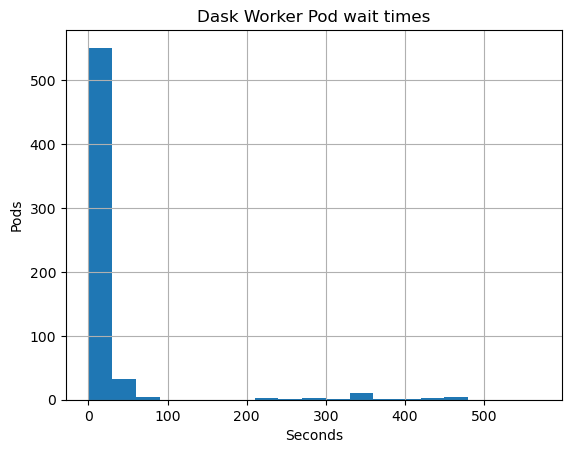

In [230]:
ax = pending_pods.hist(bins=range(0, 600, 30))
ax.set_title("Dask Worker Pod wait times")
ax.set_xlabel("Seconds")
ax.set_ylabel("Pods")

Text(0, 0.5, 'Pods')

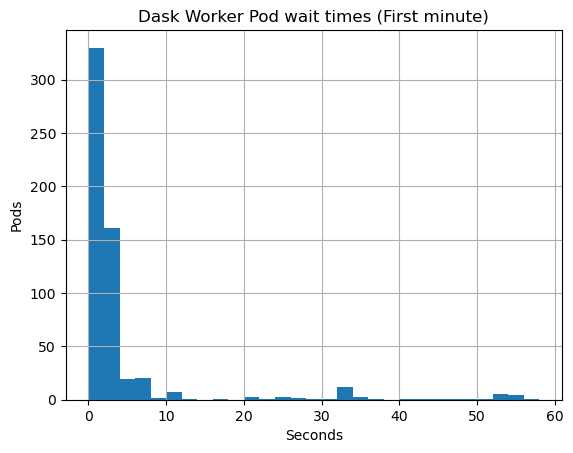

In [231]:
ax = pending_pods.hist(bins=range(0, 60, 2))
ax.set_title("Dask Worker Pod wait times (First minute)")
ax.set_xlabel("Seconds")
ax.set_ylabel("Pods")

Here we can see that most users get their worker Pods scheduled in less than 10 seconds. 

### Running pods

In [235]:
running_pods = p.query_range(
    'kube_pod_status_phase{phase=~"Running|ContainerCreating",namespace="default"}',
    start_time,
    end_time,
    "1s",
)
pending_pods = p.query_range(
    'kube_pod_status_phase{phase=~"Pending",namespace="default"}',
    start_time,
    end_time,
    "1s",
)
running_pods = running_pods[
    running_pods.columns.drop(list(running_pods.filter(regex="prepull")))
]
pending_pods = pending_pods[
    pending_pods.columns.drop(list(pending_pods.filter(regex="prepull")))
]

In [236]:
nodes = p.query_range("count(kube_node_info)", start_time, end_time, "1s")
nodes.columns = ["Available GPUs"]
nodes["Available GPUs"] = nodes["Available GPUs"] * 2
nodes

,Available GPUs
2023-02-20 15:45:06,12.0
2023-02-20 15:45:07,12.0
2023-02-20 15:45:08,12.0
2023-02-20 15:45:09,12.0
2023-02-20 15:45:10,12.0
...,...
2023-02-20 17:22:16,30.0
2023-02-20 17:22:17,30.0
2023-02-20 17:22:18,30.0
2023-02-20 17:22:19,30.0


In [237]:
nodes["Utilized GPUs"] = running_pods.sum(axis=1)
# nodes["Requested GPUs"] = pending_pods.sum(axis=1)
nodes

,Available GPUs,Utilized GPUs
2023-02-20 15:45:06,12.0,8.0
2023-02-20 15:45:07,12.0,8.0
2023-02-20 15:45:08,12.0,8.0
2023-02-20 15:45:09,12.0,8.0
2023-02-20 15:45:10,12.0,8.0
...,...,...
2023-02-20 17:22:16,30.0,NaN
2023-02-20 17:22:17,30.0,NaN
2023-02-20 17:22:18,30.0,NaN
2023-02-20 17:22:19,30.0,NaN


<AxesSubplot: >

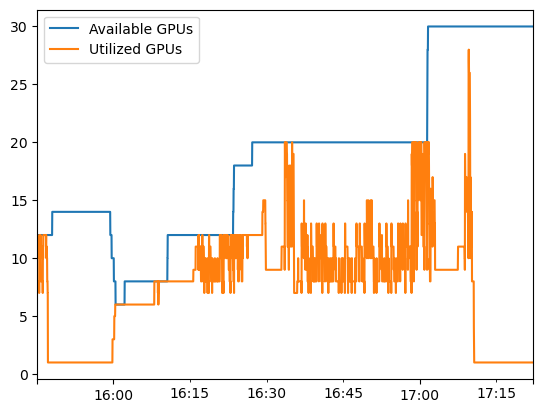

In [238]:
nodes.plot()

In [239]:
gpu_hours_utilized = nodes["Utilized GPUs"].sum() / 60 / 60
gpu_hours_utilized

12.381388888888889

In [240]:
gpu_hours_cost = nodes["Available GPUs"].sum() / 60 / 60
gpu_hours_cost

30.240555555555556

In [241]:
time_spent_pending = pending_pods.sum(axis=1).sum() / 60 / 60
time_spent_pending

2.03

In [242]:
overhead = (1 - (gpu_hours_utilized / gpu_hours_cost)) * 100
str(int(overhead)) + "% overhead"

'59% overhead'

## Teardown

Finally to clean everything up we can delete our GKE cluster.

In [43]:
! gcloud container clusters delete multi-tenant-rapids --region us-central1 --quiet

Deleting cluster multi-tenant-rapids...done.                                   
Deleted [https://container.googleapis.com/v1/projects/nv-ai-infra/zones/us-central1/clusters/multi-tenant-rapids].
